In [1]:
import os
import json
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import yaml
import numpy as np
from datetime import datetime
import shutil
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Image
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, auc

# Object detection using YOLO bounding boxes

## 1. Data preparation

We need to convert and reorganize the dataset into YOLO format. This involves:  
1. **Creating the required directory structure** (`images/` and `labels/` for `train`, `val`, `test`).  
2. **Extracting bounding boxes** from JSON annotations, filtering only rectangles.  
3. **Normalizing coordinates** to YOLO format (`class x_center y_center width height`).  
4. **Copying images and saving annotations** in the correct locations.  

In [ ]:
# Define dataset paths
raw_data_dir = "raw data"
yolo_data_dir = "data_object_detection_yolo"

# Create YOLO folder structure
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(yolo_data_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(yolo_data_dir, "labels", split), exist_ok=True)

# Function to convert bounding boxes to YOLO format
def convert_bbox_to_yolo(img_w, img_h, bbox):
    x_min, y_min = bbox[0]
    x_max, y_max = bbox[1]

    # Convert to YOLO format
    x_center = ((x_min + x_max) / 2) / img_w
    y_center = ((y_min + y_max) / 2) / img_h
    bbox_width = (x_max - x_min) / img_w
    bbox_height = (y_max - y_min) / img_h

    return f"0 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Process each dataset split
for split in ["train", "val", "test"]:
    img_src_dir = os.path.join(raw_data_dir, split, "img")
    ann_src_dir = os.path.join(raw_data_dir, split, "ann")

    img_dest_dir = os.path.join(yolo_data_dir, "images", split)
    ann_dest_dir = os.path.join(yolo_data_dir, "labels", split)

    image_files = {os.path.splitext(f)[0]: f for f in os.listdir(img_src_dir) if f.endswith((".jpg", ".png", ".jpeg"))}

    for json_file in os.listdir(ann_src_dir):
        if not json_file.endswith(".json"):
            continue

        base_name = json_file.replace(".jpg.json", "").replace(".png.json", "").replace(".jpeg.json", "")

        # Find the corresponding image file
        if base_name not in image_files:
            print(f"Skipping {json_file}: No matching image found")
            continue

        img_name = image_files[base_name]
        img_path = os.path.join(img_src_dir, img_name)
        json_path = os.path.join(ann_src_dir, json_file)

        # Load annotation JSON
        with open(json_path, "r") as f:
            data = json.load(f)

        img_width, img_height = data["size"]["width"], data["size"]["height"]
        yolo_annotations = []

        # Process objects (only rectangles)
        for obj in data["objects"]:
            if obj["geometryType"] == "rectangle":
                bbox = obj["points"]["exterior"]
                yolo_annotations.append(convert_bbox_to_yolo(img_width, img_height, bbox))

        # Save YOLO annotations
        if yolo_annotations:
            yolo_label_path = os.path.join(ann_dest_dir, base_name + ".txt")
            with open(yolo_label_path, "w") as f:
                f.write("\n".join(yolo_annotations))

        # Copy image to YOLO dataset
        shutil.copy(img_path, img_dest_dir)


Let's make sure that we have the same number of images and annotations. This can also be compared to our `02_raw_data_analysis.ipynb`.

In [ ]:
data_counts = {"Split": [], "Images": [], "Annotations": []}

# Count images and annotations in each split
for split in ["train", "val", "test"]:
    img_dir = os.path.join(yolo_data_dir, "images", split)
    ann_dir = os.path.join(yolo_data_dir, "labels", split)

    num_images = len([f for f in os.listdir(img_dir) if f.endswith((".jpg", ".png", ".jpeg"))])
    num_annotations = len([f for f in os.listdir(ann_dir) if f.endswith(".txt")])

    data_counts["Split"].append(split)
    data_counts["Images"].append(num_images)
    data_counts["Annotations"].append(num_annotations)

df_counts = pd.DataFrame(data_counts)
df_counts

,Split,Images,Annotations
0,train,574,574
1,val,82,82
2,test,61,61


Let's display the new data structure:

In [ ]:
for root, dirs, files in os.walk(yolo_data_dir):
    level = root.replace(yolo_data_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files[:2]:                                     # Show only first 2 files per folder
        print(f"{sub_indent}{f}")

data_object_detection_yolo/
    images/
        test/
            IMG0003297.jpg
            IMG0003298.jpg
        train/
            IMG0000019.jpg
            IMG0000025.jpg
        val/
            IMG0003733.jpg
            IMG0003734.jpg
    labels/
        test/
            IMG0003297.txt
            IMG0003298.txt
        train/
            IMG0000019.txt
            IMG0000025.txt
        val/
            IMG0003733.txt
            IMG0003734.txt


In the next step, we need to create the yaml file necessary to use the YOLO model.

In [ ]:
# Define the paths for train, val, and test images
data_yaml = {
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",  # Optional
    "nc": 1,  # Number of classes
    "names": ["fractured"]  # Class names
}

# Save the updated YAML file
yaml_path = os.path.join("data_object_detection_yolo", "data.yaml")
with open(yaml_path, "w") as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

print(f"data.yaml created at: {yaml_path}")


data.yaml created at: data_object_detection_yolo\data.yaml


## 2. Train YOLO model

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set dataset path
dataset_path = "/content/drive/MyDrive/data_object_detection_yolo"

# Verify the dataset structure
os.listdir(dataset_path)

model_path = "/content/drive/MyDrive/yolo_models/yolov8l_2025-02-07_18-23-13.pt"
# model_path = None

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/data_object_detection_yolo/data.yaml, epochs=200, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train163, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /content/drive/MyDrive/data_object_detection_yolo/labels/train.cache... 574 images, 0 backgrounds, 0 corrupt: 100%|██████████| 574/574 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/data_object_detection_yolo/labels/val.cache... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]


Plotting labels to runs/detect/train163/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train163
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      7.13G      2.768      4.382      1.947         28        640: 100%|██████████| 36/36 [00:28<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         82         91      0.111     0.0659     0.0176    0.00529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      7.35G      2.631      2.866      1.857         32        640: 100%|██████████| 36/36 [00:25<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         82         91      0.111     0.0659     0.0176    0.00529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      7.38G      2.696      2.879      1.925         22        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         82         91   0.000293     0.0769   0.000155   4.31e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      7.44G      2.721      2.685      1.942         24        640: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         82         91   0.000293     0.0769   0.000155   4.31e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      7.45G      2.618      2.501       1.85         35        640: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         82         91      0.102      0.033    0.00939    0.00302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      7.44G      2.593      2.499      1.839         29        640: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         82         91      0.064     0.0879     0.0266    0.00865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      7.42G      2.458       2.37       1.75         28        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         82         91      0.637      0.187      0.199     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      7.43G      2.457      2.267      1.764         29        640: 100%|██████████| 36/36 [00:24<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all         82         91      0.169       0.11     0.0874     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      7.44G      2.453      2.322      1.748         29        640: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         82         91      0.296      0.181       0.16     0.0488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      7.42G       2.44      2.318      1.758         33        640: 100%|██████████| 36/36 [00:25<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         82         91   0.000837      0.176    0.00891    0.00215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      7.42G      2.427      2.263      1.735         28        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         82         91      0.178      0.231      0.132     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200       7.4G      2.369      2.218       1.77         41        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         82         91      0.334      0.292      0.206     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      7.42G      2.346      2.088      1.673         41        640: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         82         91      0.473      0.275      0.273     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      7.45G      2.344      2.145      1.684         30        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         82         91      0.367      0.308      0.259     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      7.42G      2.301      2.085      1.695         31        640: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         82         91      0.459      0.363      0.334      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      7.42G      2.206      1.942      1.623         42        640: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         82         91      0.335      0.407        0.3     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      7.44G      2.262      1.999      1.695         27        640: 100%|██████████| 36/36 [00:25<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         82         91      0.382      0.209      0.243     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      7.42G      2.283      1.975      1.635         30        640: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         82         91      0.214      0.165      0.152     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      7.42G      2.227      1.952      1.637         27        640: 100%|██████████| 36/36 [00:25<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all         82         91      0.378      0.308      0.308     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      7.42G      2.238      1.949       1.66         26        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         82         91      0.452      0.242      0.229     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      7.41G      2.236      1.946      1.652         35        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         82         91      0.466      0.286      0.301      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      7.41G      2.167      1.866      1.587         22        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         82         91      0.418      0.407      0.342      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      7.42G      2.144      1.806      1.581         24        640: 100%|██████████| 36/36 [00:24<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         82         91      0.498      0.327      0.339      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      7.41G      2.115      1.794       1.56         40        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         82         91      0.491      0.382      0.334      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      7.42G      2.096       1.78      1.601         25        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         82         91      0.405      0.359      0.273     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      7.42G      2.178       1.88      1.624         35        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         82         91      0.342      0.385      0.315     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      7.45G      2.101      1.752      1.558         27        640: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         82         91      0.353      0.308      0.217     0.0642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      7.41G      2.038      1.788      1.526         35        640: 100%|██████████| 36/36 [00:25<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         82         91       0.59       0.33      0.377      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      7.42G      2.021      1.683      1.513         25        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         82         91      0.528      0.385      0.377      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      7.42G      2.011      1.631      1.517         21        640: 100%|██████████| 36/36 [00:24<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         82         91      0.437      0.374      0.356      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      7.42G      1.996      1.619       1.52         25        640: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         82         91      0.384      0.336      0.327      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      7.41G      2.004      1.606      1.516         30        640: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all         82         91      0.641      0.363      0.403      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      7.42G      1.992       1.63       1.52         30        640: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         82         91      0.397      0.352      0.327      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      7.42G      2.025      1.647      1.546         41        640: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         82         91      0.396      0.389        0.3      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      7.43G      1.976      1.642      1.524         25        640: 100%|██████████| 36/36 [00:25<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         82         91      0.493      0.429      0.383      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      7.43G      1.943      1.543      1.474         42        640: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         82         91      0.453      0.341      0.358      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      7.43G      1.983      1.635      1.546         22        640: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         82         91      0.437      0.429       0.35      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      7.42G      1.909      1.514      1.479         37        640: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         82         91      0.463      0.407      0.425       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      7.43G      1.969      1.544      1.523         42        640: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         82         91       0.49      0.407      0.385      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      7.42G      1.912      1.527      1.459         38        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         82         91      0.567      0.418      0.433      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      7.43G      1.914       1.48      1.475         30        640: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         82         91      0.708      0.363      0.452      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      7.42G      1.896      1.473       1.45         32        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         82         91      0.524      0.495      0.396      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      7.43G      1.842      1.443      1.463         40        640: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         82         91      0.396      0.382      0.325      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      7.41G      1.897      1.463      1.465         33        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         82         91      0.494      0.407      0.422      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      7.42G      1.889      1.449      1.453         23        640: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         82         91       0.54      0.473      0.478      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      7.43G       1.81      1.435      1.436         37        640: 100%|██████████| 36/36 [00:25<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         82         91      0.588      0.516      0.507      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      7.42G      1.778      1.361      1.409         38        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         82         91      0.588      0.495      0.511      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      7.42G      1.863      1.356      1.429         28        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all         82         91      0.617      0.462      0.435      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      7.42G      1.785      1.316      1.382         30        640: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         82         91      0.607      0.429       0.47        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      7.43G      1.767      1.282      1.382         28        640: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         82         91      0.567      0.407      0.434      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      7.43G      1.796      1.302      1.409         23        640: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         82         91      0.582      0.459      0.456      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      7.43G      1.756      1.298      1.402         34        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         82         91      0.478      0.452      0.417      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      7.42G      1.721      1.229      1.357         25        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         82         91      0.573      0.495      0.493      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      7.45G      1.758      1.268        1.4         29        640: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         82         91      0.645      0.396      0.468      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      7.44G      1.726      1.243      1.367         16        640: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         82         91      0.589       0.56      0.559      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      7.42G      1.736      1.228      1.369         43        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         82         91      0.703      0.473      0.516      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      7.42G      1.688      1.239      1.374         29        640: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         82         91      0.567      0.518      0.482      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      7.42G      1.698      1.186      1.384         28        640: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         82         91      0.613      0.473      0.486       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      7.43G       1.71      1.217      1.387         35        640: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         82         91      0.488      0.473      0.433      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      7.43G      1.706      1.201      1.343         33        640: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         82         91      0.538       0.56      0.474      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      7.41G       1.72        1.2      1.349         40        640: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         82         91      0.644      0.418      0.389      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      7.41G      1.654      1.157      1.317         33        640: 100%|██████████| 36/36 [00:29<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         82         91      0.583      0.476      0.466      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      7.42G      1.653      1.142      1.337         23        640: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         82         91      0.466       0.48      0.405      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      7.45G      1.679      1.169      1.333         28        640: 100%|██████████| 36/36 [00:25<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         82         91      0.646      0.396      0.458      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      7.44G      1.636      1.089      1.326         23        640: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         82         91      0.603      0.505      0.526      0.205
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 55, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



65 epochs completed in 0.526 hours.
Optimizer stripped from runs/detect/train163/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train163/weights/best.pt, 52.0MB

Validating runs/detect/train163/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


                   all         82         91      0.589       0.56      0.559      0.232
Speed: 0.2ms preprocess, 11.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train163


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

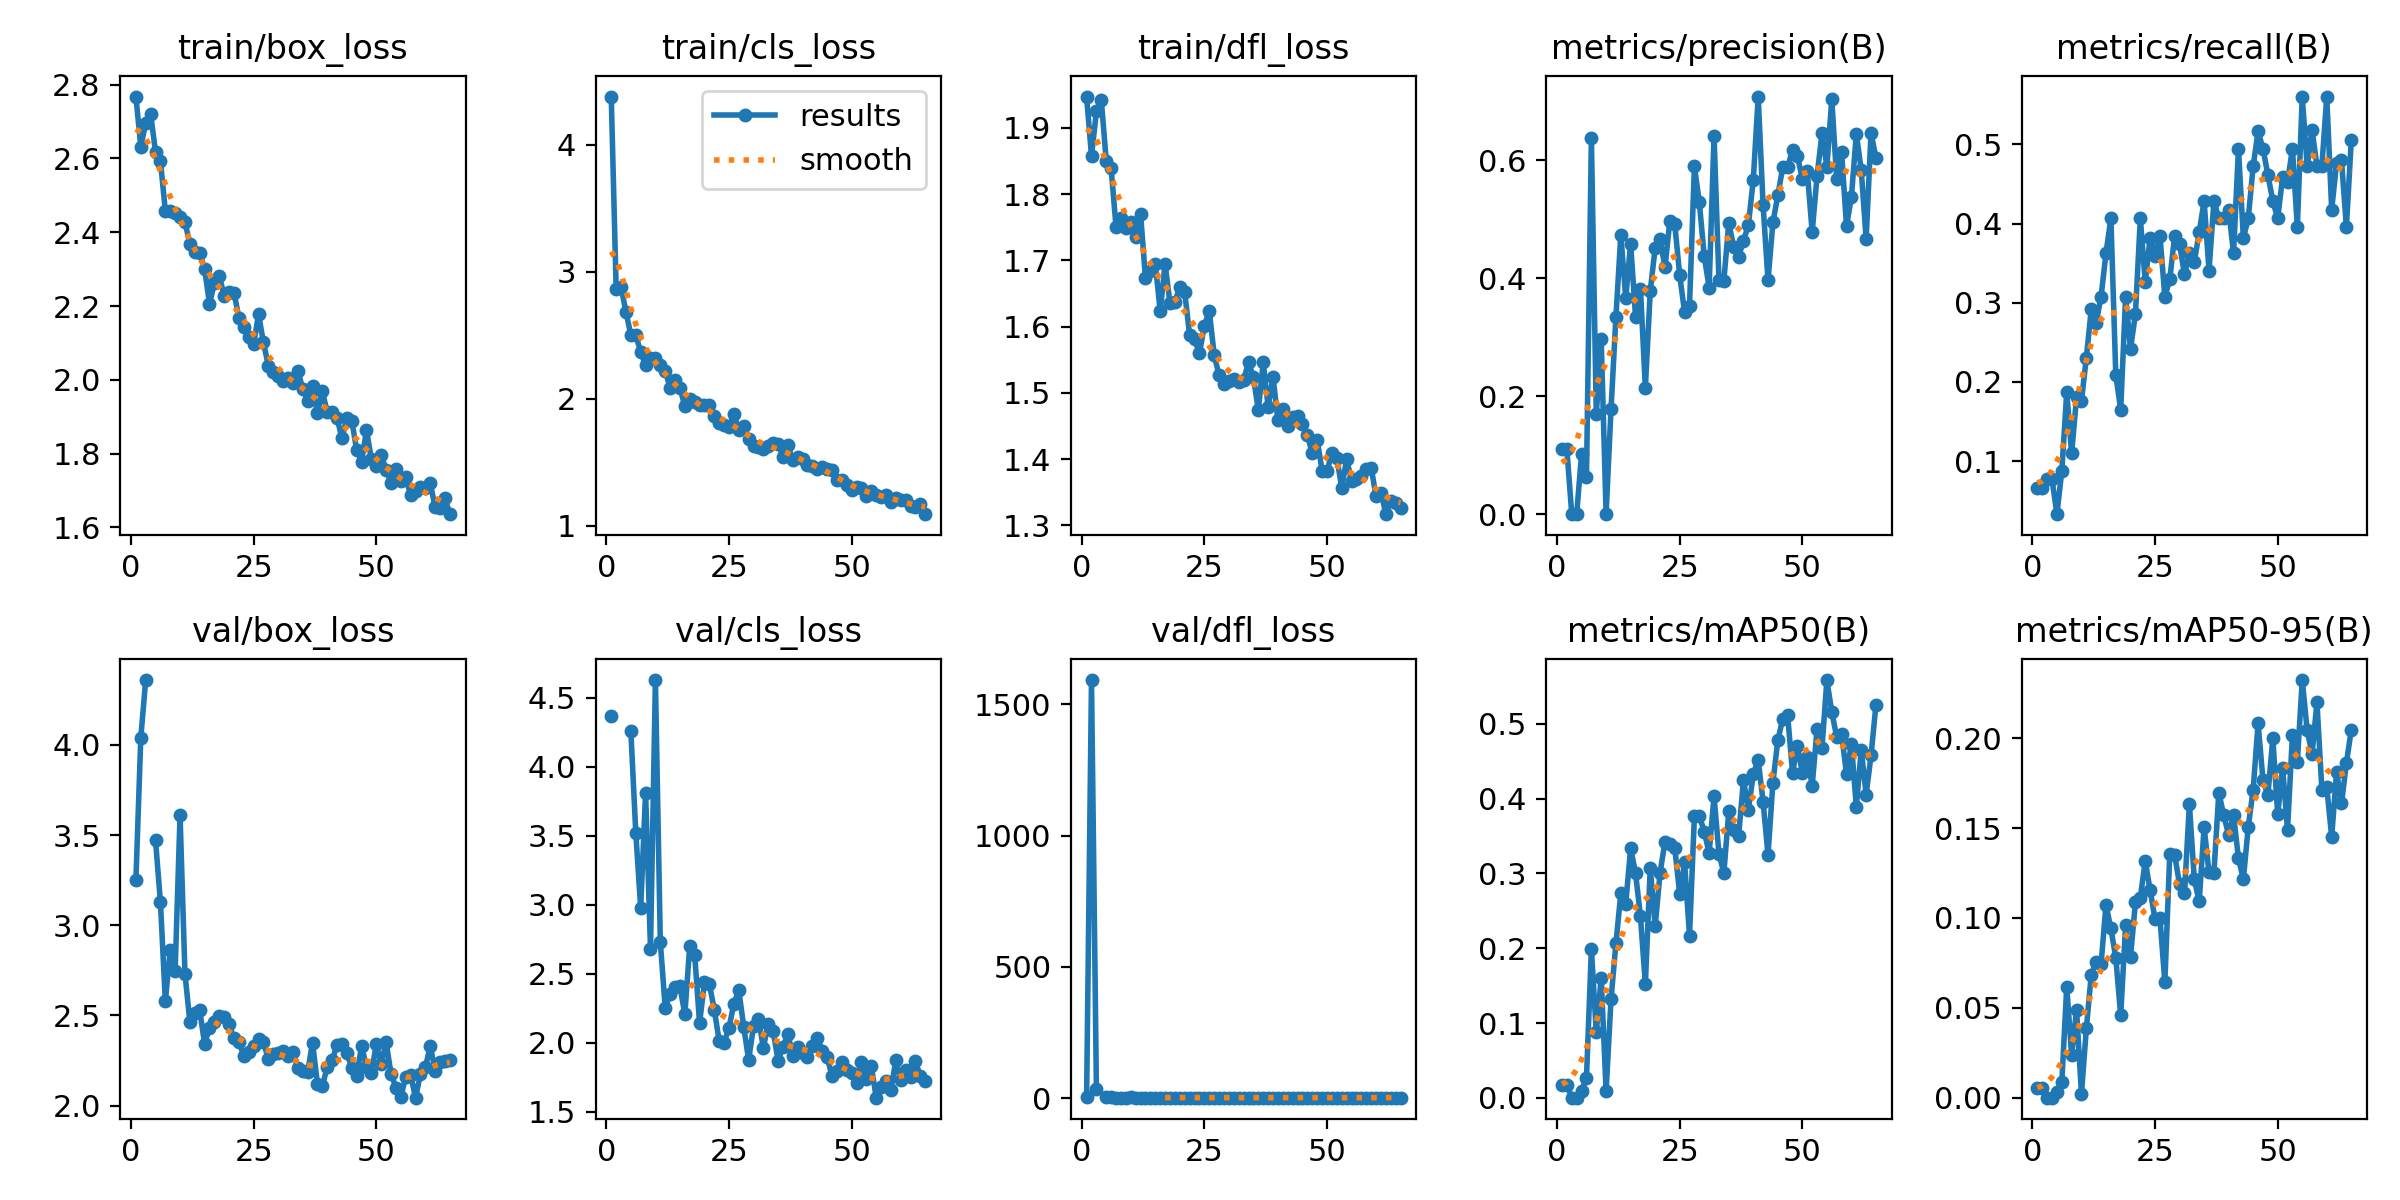

In [6]:
if model_path is None:
    # Train YOLO model

    model = YOLO("yolov8m.pt")  # Use "n" for a lightweight model
    results = model.train(data="/content/drive/MyDrive/data_object_detection_yolo/data.yaml",
                          epochs=200, imgsz=640, patience=10)

    from google.colab import files

    best_model_path = os.path.join(str(model.trainer.save_dir), "weights", "best.pt")

    files.download(best_model_path)

    # Define the target directory in Google Drive
    drive_save_dir = "/content/drive/MyDrive/yolo_models"

    # Create the directory if it doesn't exist
    os.makedirs(drive_save_dir, exist_ok=True)

    # Generate a timestamped filename
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_filename = f"yolov8l_{timestamp}.pt"

    save_path = os.path.join(drive_save_dir, model_filename)

    shutil.copy(best_model_path, save_path)

    # Display the loss curves
    display(Image(filename= f"{os.path.join(str(model.trainer.save_dir))}/results.png"))


In [6]:
if model_path is not None:
    # Load the trained model
    model = YOLO(model_path)

## YOLO Default Processing Pipeline

1. **Image Preprocessing**  
   - **Resize**: By default, the input image is resized (and sometimes padded with gray bars) to match the model’s expected dimension (e.g., 640×640), preserving aspect ratio.  
   - **Normalization**: Pixel values are typically scaled to [0,1] (e.g., dividing by 255).  

2. **Model Forward Pass**  
   - The processed image is fed into the YOLO model (a convolutional neural network).  
   - The network outputs raw predictions of bounding boxes, class scores, etc.

3. **Postprocessing**  
   - **Confidence threshold**: Confidence represents how sure the model is that the bounding box contains an object of the given class. In YOLOv8 (anchor-free), it’s often interpreted as a probability-like score that the detection is correct. YOLO discards very low-confidence detections. Default threshold is 0.25, but we set could set it even lower. This may increase the the number of found fractures, but on the other hand reduces measures such as the (mean) average precision.
   - **Non-Maximum Suppression (NMS)**: NMS is a post-processing technique used in object detection to remove duplicate and overlapping bounding boxes, keeping only the most confident predictions. It works by first sorting boxes by confidence score, then iteratively selecting the highest-confidence box and suppressing others with high Intersection over Union (IoU). This ensures that each detected object is represented by a single, precise bounding box, improving detection accuracy and reducing redundant predictions. By default, YOLO applies NMS to remove overlapping or duplicate boxes. The default IoU threshold is usually around 0.45 (meaning boxes with an overlap ≥0.45 are suppressed).  
   - The final set of predictions (per class) includes:
     - **(x1, y1, x2, y2)** coordinates for each bounding box  
     - A **confidence** score (0.0 to 1.0)  
     - A **class label** for the predicted object category  


## 3. Validate the model

In [7]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
print(f"mAP50-95 = {metrics.box.map:.3f}")
print(f"mAP50 = {metrics.box.map50:.3f}")
print(f"mAP75 = {metrics.box.map75:.3f}")
metrics.box.maps  # a list contains map50-95 of each category

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 16.2MB/s]
val: Scanning /content/drive/MyDrive/data_object_detection_yolo/labels/val.cache... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


                   all         82         91      0.575      0.538      0.559      0.234
Speed: 1.2ms preprocess, 21.5ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/detect/val
mAP50-95 = 0.234
mAP50 = 0.559
mAP75 = 0.111


array([    0.23361])

## 4. Evaluate results

In [8]:
def intersection_over_union(boxA, boxB):
    """
    Computes IoU between two boxes: [xmin, ymin, xmax, ymax].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = boxAArea + boxBArea - interArea + 1e-6

    return interArea / union

def match_boxes_iou(pred_boxes, gt_boxes, iou_thresh):
    """
    Simple greedy IoU matching:
      - For each predicted box, find best IoU with any unmatched GT box.
      - If >= iou_thresh, mark it as TP and mark that GT as used.
      - Otherwise, FP.
    Returns an array of booleans (is_tp) for the predicted boxes in order.
    """
    used = np.zeros(len(gt_boxes), dtype=bool)
    is_tp = []

    for pb in pred_boxes:
        best_iou = 0.0
        best_idx = -1
        for i, gb in enumerate(gt_boxes):
            if used[i]:
                continue
            iou = intersection_over_union(pb, gb)
            if iou > best_iou:
                best_iou = iou
                best_idx = i

        if best_iou >= iou_thresh and best_idx >= 0:
            is_tp.append(True)
            used[best_idx] = True
        else:
            is_tp.append(False)

    return np.array(is_tp)

In [45]:
def visualize_detections(folder, image_name,
                         model_path,
                         pred_boxes = None):
    """
    Visualizes ground truth vs. predicted bounding boxes for a given image.

    Parameters:
    - folder (str): The dataset split to use ("train", "val", or "test").
    - image_name (str): The filename of the image (e.g., "IMG0003733.jpg").
    - model_path (str): Path to the trained YOLO model.
    """
    # Define paths for images and labels
    base_dir = "/content/drive/MyDrive/data_object_detection_yolo/"
    image_path = os.path.join(base_dir, "images", folder, image_name)
    annotation_path = os.path.join(base_dir, "labels", folder, os.path.splitext(image_name)[0] + ".txt")

    # Verify the image exists
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    print(f"Selected Image: {image_path}")
    print(f"Annotation File: {annotation_path if os.path.exists(annotation_path) else 'No annotation found'}")

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Get image dimensions
    height, width, _ = image.shape

    # Load ground truth bounding boxes
    ground_truth_boxes = []
    if os.path.exists(annotation_path):
        with open(annotation_path, "r") as file:
            for line in file:
                parts = line.strip().split()
                class_id = int(parts[0])  # Class index
                x_center, y_center, w, h = map(float, parts[1:])

                # Convert YOLO format (normalized) to pixel coordinates
                x1 = int((x_center - w / 2) * width)
                y1 = int((y_center - h / 2) * height)
                x2 = int((x_center + w / 2) * width)
                y2 = int((y_center + h / 2) * height)

                ground_truth_boxes.append((x1, y1, x2, y2, class_id))

    if pred_boxes == None:
        # Load trained YOLO model
        model = YOLO(model_path)

        # Run inference on the selected image
        results = model(image_path)

        # Extract predicted bounding boxes
        pred_boxes = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box
                conf = box.conf[0].item()  # Confidence score
                pred_boxes.append((x1, y1, x2, y2, conf))

    # Plot Ground Truth (Green) vs. Predictions (Red)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    # Plot ground truth bounding boxes (Green)
    for (x1, y1, x2, y2, class_id) in ground_truth_boxes:
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green', linewidth=2))
        plt.text(x1, y1 - 5, f"GT: fractured", color="green", fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Plot predicted bounding boxes (Red)
    for (x1, y1, x2, y2, conf) in pred_boxes:
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(x1, y2 + 15, f"Pred: {conf:.2f}", color="red", fontsize=10,
                 verticalalignment='bottom',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    plt.axis("off")
    plt.title("Ground Truth (Green) vs. Predicted (Red)")
    plt.show()

    print(f"Number of Ground Truth Boxes: {len(ground_truth_boxes)}")
    print(f"Number of Predicted Boxes: {len(pred_boxes)}")
    gt_np = np.array([box[:4] for box in ground_truth_boxes])
    pred_np = np.array([box[:4] for box in pred_boxes])

    # For demonstration, we'll just show each predicted box's best IoU with any GT box
    for i, pbox in enumerate(pred_np):
        best_iou = 0.0
        for gbox in gt_np:
            iou_val = intersection_over_union(pbox, gbox)
            if iou_val > best_iou:
                best_iou = iou_val
        print(f"Predicted box {i} best IoU: {best_iou:.3f}")

Selected Image: /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg
Annotation File: /content/drive/MyDrive/data_object_detection_yolo/labels/test/IMG0003331.txt

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg: 640x544 1 fractured, 36.8ms
Speed: 3.5ms preprocess, 36.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


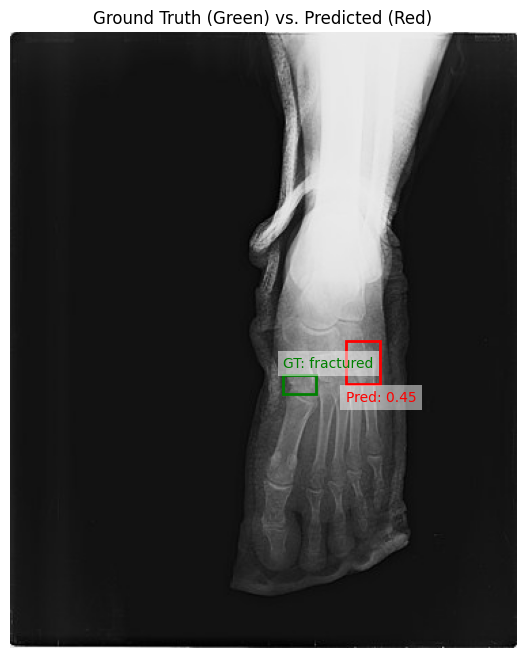

Number of Ground Truth Boxes: 1
Number of Predicted Boxes: 1
Predicted box 0 best IoU: 0.000


In [46]:
import random
folder = 'test'
image_dir = f"/content/drive/MyDrive/data_object_detection_yolo/images/{folder}"
# List all images in the validation folder
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

random_image = random.choice(image_files)
visualize_detections(folder, random_image, model_path)

Selected Image: /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg
Annotation File: /content/drive/MyDrive/data_object_detection_yolo/labels/test/IMG0003373.txt

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg: 640x544 2 fractureds, 36.9ms
Speed: 3.5ms preprocess, 36.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


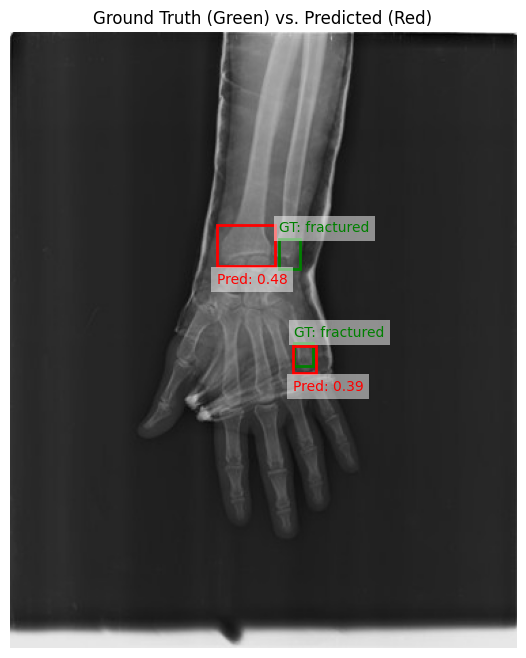

Number of Ground Truth Boxes: 2
Number of Predicted Boxes: 2
Predicted box 0 best IoU: 0.000
Predicted box 1 best IoU: 0.571


In [47]:
visualize_detections(folder, "IMG0003373.jpg", model_path)

In [20]:
test_images_dir = "/content/drive/MyDrive/data_object_detection_yolo/images/test"
test_labels_dir = "/content/drive/MyDrive/data_object_detection_yolo/labels/test"

model = YOLO(model_path)

test_images = [f for f in os.listdir(test_images_dir)
               if f.lower().endswith((".jpg", ".png", ".jpeg"))]

# We want the class ID for "fractured"
fractured_id = None
for idx, name in model.names.items():
    if name == "fractured":
        fractured_id = idx
        break

if fractured_id is None:
    raise ValueError("No class named 'fractured' in model.names!")

# storing a list of ground truth boxes (only 'fractured')
# and a list of predicted boxes (only 'fractured'), plus the predicted scores.
all_gt = []
all_pred = []
all_scores = []



for image_name in tqdm(test_images):
    image_path = os.path.join(test_images_dir, image_name)
    label_path = os.path.join(test_labels_dir, os.path.splitext(image_name)[0] + ".txt")

    # Ground truth boxes (for 'fractured')
    image = cv2.imread(image_path)
    if image is None:
        # skip broken image
        continue
    img_h, img_w = image.shape[:2]

    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                xc, yc, w, h = map(float, parts[1:])
                if cls_id == fractured_id:
                    xmin = int((xc - w/2) * img_w)
                    ymin = int((yc - h/2) * img_h)
                    xmax = int((xc + w/2) * img_w)
                    ymax = int((yc + h/2) * img_h)
                    gt_boxes.append([xmin, ymin, xmax, ymax])

    # Predictions (for 'fractured')
    results = model(image_path, imgsz=640)
    # results = model(image_path, imgsz=640, conf=0.01)

    pred_boxes = []
    scores = []
    for r in results:
        for box in r.boxes:
            cls_pred = int(box.cls[0].item())
            conf = float(box.conf[0].item())
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            if cls_pred == fractured_id:
                pred_boxes.append([x1, y1, x2, y2])
                scores.append(conf)

    all_gt.append(gt_boxes)
    all_pred.append(pred_boxes)
    all_scores.append(scores)

  0%|          | 0/61 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003569.jpg: 640x544 1 fractured, 37.1ms
Speed: 9.3ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 1/61 [00:00<00:37,  1.61it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003339.jpg: 640x544 1 fractured, 34.7ms
Speed: 3.5ms preprocess, 34.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003588.jpg: 640x544 1 fractured, 34.3ms
Speed: 2.2ms preprocess, 34.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


  5%|▍         | 3/61 [00:00<00:12,  4.82it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003671.jpg: 640x544 1 fractured, 34.3ms
Speed: 3.1ms preprocess, 34.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 34.2ms
Speed: 2.3ms preprocess, 34.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


  8%|▊         | 5/61 [00:00<00:07,  7.69it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 23.4ms
Speed: 2.2ms preprocess, 23.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003342.jpg: 640x544 (no detections), 23.3ms
Speed: 2.2ms preprocess, 23.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 11%|█▏        | 7/61 [00:00<00:05, 10.28it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003312.jpg: 640x544 (no detections), 22.6ms
Speed: 2.3ms preprocess, 22.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003374.jpg: 640x544 1 fractured, 22.7ms
Speed: 3.5ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003619.jpg: 640x544 (no detections), 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▋        | 10/61 [00:01<00:03, 14.01it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003587.jpg: 640x544 1 fractured, 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003311.jpg: 640x544 3 fractureds, 20.6ms
Speed: 2.1ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003297.jpg: 640x544 1 fractured, 20.4ms
Speed: 2.1ms preprocess, 20.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


 21%|██▏       | 13/61 [00:01<00:02, 16.57it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003397.jpg: 640x544 2 fractureds, 19.8ms
Speed: 2.7ms preprocess, 19.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 20.3ms
Speed: 2.5ms preprocess, 20.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 19.2ms
Speed: 3.5ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 16/61 [00:01<00:02, 18.18it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003509.jpg: 640x544 1 fractured, 18.6ms
Speed: 2.1ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003712.jpg: 640x544 1 fractured, 18.6ms
Speed: 2.2ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003419.jpg: 640x544 4 fractureds, 17.5ms
Speed: 2.1ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 19/61 [00:01<00:02, 19.88it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 17.6ms
Speed: 2.2ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003586.jpg: 640x544 2 fractureds, 17.5ms
Speed: 2.1ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003466.jpg: 640x544 1 fractured, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▌      | 22/61 [00:01<00:01, 21.42it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003589.jpg: 640x544 1 fractured, 17.3ms
Speed: 2.2ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg: 640x544 1 fractured, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003313.jpg: 640x544 (no detections), 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 25/61 [00:01<00:01, 22.60it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003625.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003301.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 16.6ms
Speed: 3.4ms preprocess, 16.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 28/61 [00:01<00:01, 22.62it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003398.jpg: 640x544 3 fractureds, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 16.6ms
Speed: 3.0ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003458.jpg: 640x544 1 fractured, 16.7ms
Speed: 2.3ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 31/61 [00:01<00:01, 23.32it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003459.jpg: 640x544 2 fractureds, 16.6ms
Speed: 3.0ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003310.jpg: 640x544 2 fractureds, 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003399.jpg: 640x544 1 fractured, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 56%|█████▌    | 34/61 [00:02<00:01, 24.05it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg: 640x544 2 fractureds, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003382.jpg: 640x544 1 fractured, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003564.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 37/61 [00:02<00:00, 24.47it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003309.jpg: 544x640 (no detections), 17.6ms
Speed: 2.7ms preprocess, 17.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003394.jpg: 640x544 1 fractured, 18.0ms
Speed: 3.3ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003628.jpg: 544x640 1 fractured, 17.3ms
Speed: 2.5ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▌   | 40/61 [00:02<00:00, 24.04it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003341.jpg: 544x640 1 fractured, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003332.jpg: 640x544 1 fractured, 17.9ms
Speed: 2.6ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg: 640x544 1 fractured, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████   | 43/61 [00:02<00:00, 23.79it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003477.jpg: 640x544 (no detections), 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003298.jpg: 640x544 1 fractured, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 16.9ms
Speed: 2.3ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 46/61 [00:02<00:00, 24.39it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003565.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.6ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003467.jpg: 640x544 (no detections), 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003396.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 49/61 [00:02<00:00, 23.72it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003685.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003524.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.3ms preprocess, 16.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003520.jpg: 640x544 3 fractureds, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 52/61 [00:02<00:00, 24.33it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 16.7ms
Speed: 2.4ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003338.jpg: 640x544 (no detections), 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003510.jpg: 640x544 1 fractured, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 55/61 [00:02<00:00, 24.87it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003308.jpg: 640x544 2 fractureds, 16.9ms
Speed: 3.1ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003653.jpg: 640x544 (no detections), 16.7ms
Speed: 3.2ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003654.jpg: 640x544 1 fractured, 16.7ms
Speed: 2.4ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▌| 58/61 [00:03<00:00, 25.09it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003545.jpg: 640x544 1 fractured, 16.3ms
Speed: 3.1ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003703.jpg: 640x544 1 fractured, 16.3ms
Speed: 3.0ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003420.jpg: 544x640 2 fractureds, 16.9ms
Speed: 2.3ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


100%|██████████| 61/61 [00:03<00:00, 19.15it/s]


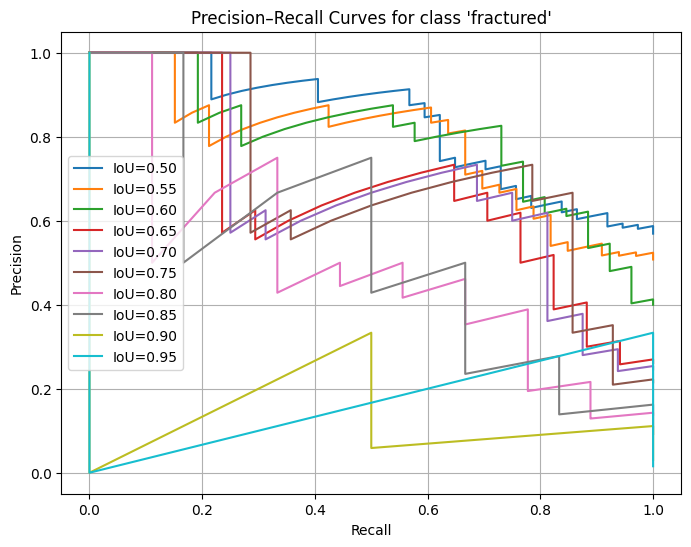

In [33]:
iou_thresholds = np.arange(0.5, 1.0, 0.05)
ap_per_iou = {}

plt.figure(figsize=(8,6))

for iou_thresh in iou_thresholds:
    matched_predictions = []  # each = { 'score': float, 'is_tp': bool }

    # Loop over every image, match boxes with ground truth at this IoU
    for gt_boxes, pred_boxes, pred_scores in zip(all_gt, all_pred, all_scores):
        gt_boxes = np.array(gt_boxes)
        pred_boxes = np.array(pred_boxes)
        pred_scores = np.array(pred_scores)

        # if len(pred_boxes) == 0:
        #     continue  # no predictions for this image

        # Match
        is_tp = match_boxes_iou(pred_boxes, gt_boxes, iou_thresh)

        # Store them
        for tp, s in zip(is_tp, pred_scores):
            matched_predictions.append({
                "score": s,
                "is_tp": tp
            })

    # precision-recall for matched predictions
    # if len(matched_predictions) == 0:
    #     continue  # no predictions at all

    scores_array = np.array([p["score"] for p in matched_predictions])
    labels_array = np.array([1 if p["is_tp"] else 0 for p in matched_predictions])

    precision, recall, thresholds = precision_recall_curve(labels_array, scores_array)
    ap = auc(recall, precision)  # Compute AP as area under PR curve
    ap_per_iou[iou_thresh] = ap

    plt.plot(recall, precision, label=f"IoU={iou_thresh:.2f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for class 'fractured'")
plt.grid(True)
plt.legend()
plt.show()

In [34]:
for iou, ap in ap_per_iou.items():
    print(f"IoU {iou:.2f}: AP = {ap:.3f}")

IoU 0.50: AP = 0.830
IoU 0.55: AP = 0.781
IoU 0.60: AP = 0.795
IoU 0.65: AP = 0.664
IoU 0.70: AP = 0.670
IoU 0.75: AP = 0.698
IoU 0.80: AP = 0.487
IoU 0.85: AP = 0.527
IoU 0.90: AP = 0.126
IoU 0.95: AP = 0.167


In [32]:
mean_ap = np.mean(list(ap_per_iou.values()))
print(f"Mean Average Precision (mAP50-95): {mean_ap:.3f}")

Mean Average Precision (mAP50-95): 0.575


## Confusion matrix

We create a confusion matrix based on whether the model detected a box with IoU>=0.5 to that of the ground truth.

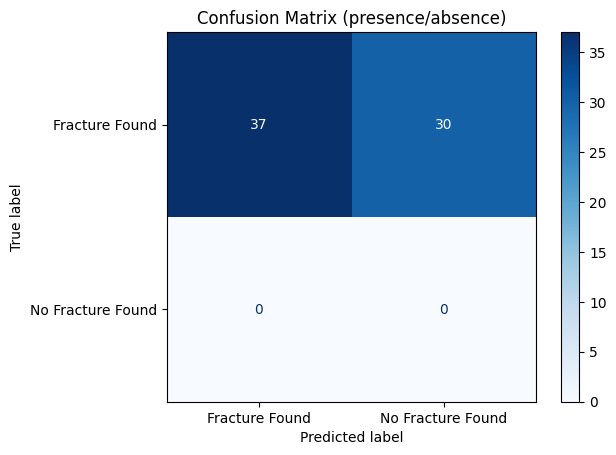

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for gt_boxes, pred_boxes in zip(all_gt, all_pred):
    # Ground truth labels (1 for each fracture)
    y_true.extend([1] * len(gt_boxes))

    if len(pred_boxes) == 0:
        y_pred.extend([0] * len(gt_boxes))  # No detections, all GT count as missed
        continue

    gt_arr = np.array(gt_boxes)
    pred_arr = np.array(pred_boxes)

    # Track which GT boxes have been matched
    matched_gt = set()

    for pbox in pred_arr:
        for i, gt_box in enumerate(gt_arr):
            iou_val = intersection_over_union(pbox, gt_box)
            if iou_val >= 0.5:
                matched_gt.add(i)

    # Assign detections (1 if GT detected, 0 otherwise)
    for i in range(len(gt_boxes)):
        y_pred.append(1 if i in matched_gt else 0)

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fracture Found", "No Fracture Found"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
